In [1]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import random
import cv2 

In [2]:
np.log(0.01)/(np.log(1- (0.7)**4))

16.772394883606545

In [3]:
rot = R.from_euler('xyz',[1.25,1.29,0.73],degrees = True)

print(np.linalg.norm(rot.as_rotvec())*57)

1.923627562251257


In [5]:
def get_points_from_CAD():
    # we consider that marker has 40 mm length
# keypoints are defined from the CAD data
    """
    defines keypoints and holes' centers in marker CS
    """
    keypoints = np.zeros((14,2))
    i = 0
    keypoints[2*i] = [6.143, 37.51]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [27.213, 28.666]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [13.161, 26.86]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [27.707, 19.26]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [38.253, 5.53]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [19.9, -27.273]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [20.4, -29.39]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1

    anchors = np.zeros((7,3))

    anchors[0] = [0.0, 0.0, 2.25]
    anchors[1] = [8.0, 11.2, 2.25]
    anchors[2] = anchors[1].copy()
    anchors[2][0] *= -1
    anchors[3] = [16.0, 0, 2.25]
    anchors[4] = anchors[3].copy()
    anchors[4][0] *= -1
    anchors[5] = [8.0, -13.86, 2.25]
    anchors[6] = anchors[5].copy()
    anchors[6][0] *= -1
    
    return keypoints, anchors[:,:2]

In [6]:
def to_rvec_tvec(tf):
    rvec = R.from_matrix(tf[:3,:3]).as_rotvec()
    tvec = tf[:3,3]
    return rvec,tvec    
    
def get_default_realsense_intrinsic():
    intr = np.eye(3, dtype=float)
    intr[0, 0] = 633.22
    intr[1, 1] = 632.515
    intr[0, 2] = 629.326
    intr[1, 2] = 360.888
    dist = np.array([[-0.0576521, 0.0680838, -0.000793749, 0.000349604, -0.021285]], dtype=float)

    return intr, dist

mtx, dist = get_default_realsense_intrinsic()
    
def get_camera_poses(dlin = 50, drot=0):
    rvec_ini = np.array([np.deg2rad(-1),np.deg2rad(1), np.pi + np.deg2rad(2)],dtype = np.float)
    tvec_ini = np.array([-2,1,160],dtype = np.float)
    
#     rvec_ini = np.array([0,0, np.pi],dtype = np.float)
#     tvec_ini = np.array([0,0,200],dtype = np.float)
    tf_ini = hom_tf(rvec_ini,tvec_ini)
    cam_rvecs_tvecs = [[rvec_ini,tvec_ini]]
    tfs = [np.eye(4)]
    tf_left = hom_tf(R.from_rotvec(np.array([0,np.deg2rad(-drot),0])).as_rotvec(),np.array([dlin,0.0,0.0]))
    tfs.append(tf_left)
#     print(tf_ini@tf_left)
    cam_rvecs_tvecs.append(to_rvec_tvec(tf_left@tf_ini))
    
    tf_right = hom_tf(R.from_rotvec(np.array([0,np.deg2rad(drot),0])).as_rotvec(),np.array([-dlin,0.0,0.0]))                 
    tfs.append(tf_right)
    cam_rvecs_tvecs.append(to_rvec_tvec(tf_right@tf_ini))
    
    tf_up = hom_tf(R.from_rotvec(np.array([np.deg2rad(drot),0,0])).as_rotvec(),np.array([0,dlin,0.0]))
    tfs.append(tf_up)
    cam_rvecs_tvecs.append(to_rvec_tvec(tf_up@tf_ini))
    
    tf_down = hom_tf(R.from_rotvec(np.array([np.deg2rad(-drot),0,0])).as_rotvec(),np.array([0,-dlin,0.0]))
    tfs.append(tf_down)
    cam_rvecs_tvecs.append(to_rvec_tvec(tf_down@tf_ini))
        
    return cam_rvecs_tvecs,tfs

In [7]:
def hom_tf(rvec,tvec):
    res = np.eye(4, dtype = np.float)
    res[:3,:3] = R.from_rotvec(rvec.flatten()).as_matrix()
    res[:3,3] = tvec.flatten()
    return res

def calc_error(reference_tf,rvecs,tvecs):
    res_tf = hom_tf(rvecs,tvecs)

    err = np.linalg.inv(reference_tf) @ res_tf
    theta = R.from_matrix(err[:3,:3]).as_rotvec()
    dt = err[:3,3]
    return np.rad2deg(theta), dt
        
points_3d,anchors = get_points_from_CAD()
points_3d = np.hstack((points_3d, np.zeros((points_3d.shape[0],1))))

cam_rvecs_tvecs,tfs = get_camera_poses()
for rvec,tvec in cam_rvecs_tvecs:
#     rvec,tvec = cam_rvecs_tvecs[0]
    cam_tf = hom_tf(rvec,tvec)
    projected_points, _ = cv2.projectPoints(points_3d, rvec, tvec, mtx, dist)
    _,rvecs, tvecs, _ = cv2.solvePnPRansac(points_3d, projected_points, mtx, dist)
    print(calc_error(cam_tf,rvecs,tvecs))

(array([ 3.99452480e-06, -6.19324224e-06,  1.23706135e-06]), array([-7.91545890e-07, -3.24107864e-07, -2.82957694e-06]))
(array([ 1.05280913e-05, -5.38991499e-08,  1.71710869e-06]), array([1.10898503e-06, 1.35725590e-06, 2.09784486e-06]))
(array([-7.96851595e-06,  5.36679742e-06,  1.25440935e-06]), array([ 1.38306924e-06, -8.78279145e-07,  5.09972054e-06]))
(array([-2.04865916e-05, -2.92270890e-06,  1.16447499e-06]), array([ 2.31929242e-06,  4.04589060e-06, -1.48548243e-05]))
(array([-1.23962603e-05,  1.17510577e-06, -2.02139254e-07]), array([1.02137030e-06, 4.91476342e-07, 7.01500591e-06]))


/tmp/ipykernel_66386/2108698356.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rvec_ini = np.array([np.deg2rad(-1),np.deg2rad(1), np.pi + np.deg2rad(2)],dtype = np.float)
/tmp/ipykernel_66386/2108698356.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tvec_ini = np.array([-2,1,160],dtype = np.float)
/tmp/ipykernel_66386/21044875

In [8]:
# generate poses
mu, sigma = 0, 0.8 # mean and standard deviation
s = np.random.normal(mu, sigma, 1)

all_poses = {}

np.random.seed(0)

i = 0
N_poses = 1500
for rvec,tvec in cam_rvecs_tvecs:
#     cam_tf = hom_tf(rvec,tvec)
    projected_points, _ = cv2.projectPoints(points_3d, rvec, tvec, mtx, dist)
#     _,rvecs, tvecs, _ = cv2.solvePnPRansac(points_3d, projected_points, mtx, dist)
    av_vals = []
    for iters in range(N_poses): 
        projected_points_copy = projected_points.copy()
        for pt in projected_points_copy:
            pt[0][0] += np.random.normal(mu, sigma, 1)
            pt[0][1] += np.random.normal(mu, sigma, 1)    
        ret,rvecs, tvecs, inliers = cv2.solvePnPRansac(points_3d, projected_points_copy, mtx, dist,iterationsCount = 50,
                                                       reprojectionError = sigma * 0.8 , flags = cv2.SOLVEPNP_SQPNP)

        if ret:
            av_vals.append([rvecs, tvecs])
    
    all_poses[i] = av_vals
    i+=1                     

In [9]:
def get_cam_i_in_robot():
    rvec = np.zeros(3)
    tvec = np.array([30,-200,300])
    
    return hom_tf(rvec,tvec)

tf_cam_i_in_robot = get_cam_i_in_robot()
rvec,tvec = cam_rvecs_tvecs[0]
cam_tf_ref = hom_tf(rvec,tvec)

sock_in_robot_tf_ref = tf_cam_i_in_robot @ cam_tf_ref

/tmp/ipykernel_66386/2104487552.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  res = np.eye(4, dtype = np.float)


In [10]:
def get_random_pose_error(dt = 0,dr = 0):
    mu, sigma = 0, 0.33 # mean and standard deviation
    rot_axis = np.random.normal(mu, sigma, (3,1))
    rot_axis /= np.linalg.norm(rot_axis)
    
    sigma = dr/3
    rot_ange = np.deg2rad(np.random.normal(mu, sigma, 1))
    rvec = rot_ange * rot_axis
    
    sigma = (0.57 * dt)/3
    tvec = np.random.normal(mu, sigma, (3))
    rot_mtx =  hom_tf(rvec,tvec)
    return rot_mtx


def pick_random_poses(all_poses, n = 5):
    picked_poses = []
    for i in range(n):
        sample = random.sample(all_poses[i], 1)
        # моделируется ошибка прихода в позу камеры random_pose_error 
        from_cj_to_ci = np.linalg.inv(tfs[i])
        tf_socket_in_cam_j = hom_tf(sample[0][0],sample[0][1])
        
        robot_error = get_random_pose_error(1.0,1)
        tf_cam_i_in_robot = get_cam_i_in_robot()
        
        cam_j_in_robot = tf_cam_i_in_robot @ from_cj_to_ci
        cam_j_in_robot_with_error = cam_j_in_robot @ robot_error
        
        socket_in_robot = cam_j_in_robot_with_error @ tf_socket_in_cam_j
        
        rvec = R.from_matrix(socket_in_robot[:3,:3]).as_rotvec()
        picked_poses.append([rvec,socket_in_robot[:3,3]])
    
    picked_poses = np.array(picked_poses).reshape(-1,2,3)
    
    return picked_poses

def get_thresholds(k1 = 0.8,k2 = 0.8,k3=0.9):
    
    dy = k1 * 2.5
    dx = k2 *4
    dtheta_1 = k3* (3 + 2-2)
    dtheta_2 = k3* (4 + 1-1)
    dtheta_3 = k3* (1 )
    
    return dx,dy,dtheta_1,dtheta_2,dtheta_3

dx,dy,dtheta_1,dtheta_2,dtheta_3 = get_thresholds()

In [11]:
lin_errors = []
theta_errors = []
fail_lin = 0
fail_rot = 0

n_trials = 500
for i in range(n_trials):
    res = np.empty((0,2,3))
    for q in range(1):
        picked_poses = pick_random_poses(all_poses,n = 5)
        res = np.vstack((res,picked_poses))
    
    r = R.from_rotvec(res[:,0,:])
    averaged_tvec = res[:,1,:].mean(axis=0)
    rvec_mean = r.mean().as_rotvec()
    
    aver_tf_robot = hom_tf(rvec_mean,averaged_tvec)
    aver_tf_robot_error = aver_tf_robot @ get_random_pose_error(1.0,0.5)
    rvec,tvec = to_rvec_tvec(aver_tf_robot_error)
    
    theta, lin = calc_error(sock_in_robot_tf_ref,rvec,tvec)
    lin_errors.append(lin)
    theta_errors.append(theta)
#     print(theta)
    if (np.abs(theta[0]) > dtheta_1 or np.abs(theta[1]) > dtheta_2 or np.abs(theta[2]) > dtheta_3) :
        fail_rot +=1
    elif (np.abs(lin[0]) > dx 
        or np.abs(lin[1])>dy):
        fail_lin +=1
        
print("fail_lin", fail_lin, "fail_rot",fail_rot)
print("success rate",(n_trials*1.0 - (fail_lin+fail_rot))/n_trials)   

/tmp/ipykernel_66386/2104487552.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  res = np.eye(4, dtype = np.float)


fail_lin 1 fail_rot 6
success rate 0.986


In [12]:
lin_errors = np.array(lin_errors)
print((lin_errors[:,]).mean(axis = 0))
print((lin_errors).std(axis = 0))

[-0.00466177  0.06736351 -0.00165183]
[0.34414732 0.83404108 0.55936167]


In [13]:
print(np.linalg.norm((lin_errors[:,]),axis=1).mean())
print(np.linalg.norm(lin_errors,axis=1).std())

0.6529527445854861
0.8397394804073276


[-0.00466177  0.06736351 -0.00165183]
[-0.05057351  0.03517767 -0.00136232]


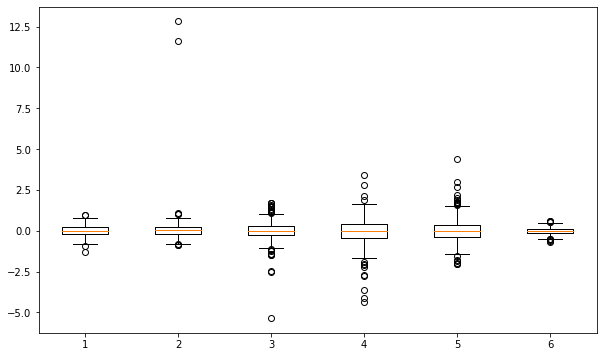

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

lin_errors = np.array(lin_errors)
theta_errors = np.array(theta_errors)
# print(np.linalg.norm((lin_errors[:,]),axis=1).mean())
# print(np.linalg.norm(theta_errors,axis=1).mean())
print((lin_errors[:,]).mean(axis = 0))
print((theta_errors).mean(axis = 0))

lin_errors = np.array(lin_errors)
fig, ax1 = plt.subplots(figsize=(10, 6))
# axs[0, 0].boxplot(data)
bp = ax1.boxplot([lin_errors[:,0],lin_errors[:,1],lin_errors[:,2],theta_errors[:,0],theta_errors[:,1],theta_errors[:,2]])
plt.show()

In [15]:
print(np.linalg.norm((theta_errors[:,]),axis=1).mean())
print(np.linalg.norm(theta_errors,axis=1).std())

0.8502196349049187
0.6059531104572962


In [16]:
print(np.linalg.norm(theta_errors,axis=1).std())

0.6059531104572962


In [17]:
print(np.abs((lin_errors[:,])).min(axis = 0))
print(theta_errors.min(axis = 0))

[0.00046303 0.00016375 0.00040902]
[-4.37893624 -2.04480388 -0.66141569]


In [18]:
theta_errors.std(axis=0)

array([0.74683149, 0.69996585, 0.19633168])

In [19]:
theta_errors

array([[-0.33573977,  0.05725519,  0.20033683],
       [-0.30551604,  2.66428028, -0.66141569],
       [-0.43868052,  0.15651711, -0.042214  ],
       ...,
       [-1.00782817,  0.03090992, -0.23125078],
       [ 0.40091109, -0.0811317 ,  0.1029362 ],
       [-0.59619272,  0.90938569,  0.01844006]])

In [20]:
    res = np.empty((0,2,3))
#         res = np.vstack((res,selected_vals))
#     print(res.shape)
#     print(selected_vals.shape)
#     for rvec,tvec in selected_vals:
#         theta, lin = calc_error(sock_in_tool_tf_ref,rvec,tvec)

In [21]:
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [22]:
# proper averaging

# random.seed(0)
n = 10
selected_vals = random.sample(av_vals, n)
selected_vals = np.array(selected_vals).reshape(-1,2,3)
print("non averaged")
for rvec,tvec in selected_vals:
    theta, lin = calc_error(cam_tf,rvec,tvec)
    print(np.linalg.norm(theta),np.linalg.norm(lin))

n = 30
print("averaged by n=",n)
for i in range(50):
    selected_vals = random.sample(av_vals, n)
    selected_vals = np.array(selected_vals).reshape(-1,2,3)
    # averaged_vals = .mean(axis=0)
    r = R.from_rotvec(selected_vals[:,0,:])
    averaged_tvec = selected_vals[:,1,:].mean(axis=0)

    theta, lin = calc_error(cam_tf,r.mean().as_rotvec(),averaged_tvec)
    print(np.linalg.norm(theta),np.linalg.norm(lin))
#     for val in selected_vals:
#         theta, lin = calc_error(cam_tf,val[0],val[1])
#         print(np.linalg.norm(theta),np.linalg.norm(lin))

non averaged
1.6999602685292783 1.8035581044035789
1.3365474624996618 2.050654289320715
0.7852160448449095 0.057046710814912874
28.305655447750354 12.398484764226982
0.44927159430772645 0.3177421047352013
0.5245490529258525 0.8350769984976039
0.49885904216341653 0.15968034331600456
0.812316641930556 0.9139093764632326
1.8035437574817723 1.1848181335439136
1.2677522094323386 1.0232937623350271
averaged by n= 30
0.5209048937745394 0.2367139937958114
0.4513118885092522 0.08590946575693303
0.19523682498944872 0.05435082189459821
0.25090116981060373 0.04713616880818065
0.3307149995471815 0.15019390803436866
0.373156611327027 0.07964498641930896
0.22452651732027334 0.1496374113823882
0.32361510506227664 0.11721704524219907
0.5136880112294037 0.19220987417073315
0.35411024342338704 0.3052233410844849
1.2103583633281438 0.7861816189406882
0.19092673115622366 0.27756930098938964
0.1573324196152905 0.14048031857104046
0.2956129293017008 0.0408788995258269
0.30171489535841595 0.11823827276391055


/tmp/ipykernel_66386/2104487552.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  res = np.eye(4, dtype = np.float)


In [23]:
selected_vals.reshape(-1,2,3)[:,0,:]

array([[ 1.47328213e-03, -1.67532499e-02, -3.10792737e+00],
       [ 1.35943569e-02, -3.77918863e-03, -3.10659802e+00],
       [ 2.70822162e-02, -7.41867789e-02, -3.10275830e+00],
       [ 1.70781521e-02, -1.43633837e-02, -3.11049168e+00],
       [ 6.03052796e-02, -3.82119591e-02, -3.10966508e+00],
       [-4.17117353e-03, -2.77694845e-02, -3.10162076e+00],
       [ 3.87037672e-02, -2.53534694e-02, -3.10568909e+00],
       [-6.58515359e-03, -1.04100445e-02, -3.10220232e+00],
       [ 4.32241376e-02, -9.42086927e-02, -3.12133863e+00],
       [ 3.99058261e-04, -3.45584330e-02, -3.10721313e+00],
       [-4.86914126e-02, -9.33297911e-02, -3.09528536e+00],
       [ 2.27245912e-02,  5.36390646e-03, -3.10943463e+00],
       [-1.48532188e-03, -3.82414920e-02, -3.09946212e+00],
       [ 1.56224894e-02, -4.63349490e-02, -3.10733317e+00],
       [ 2.83335315e-02, -8.59121849e-03, -3.10625425e+00],
       [ 5.55877445e-02, -4.65307496e-02, -3.10609305e+00],
       [-2.39015984e-02,  1.20655746e-04

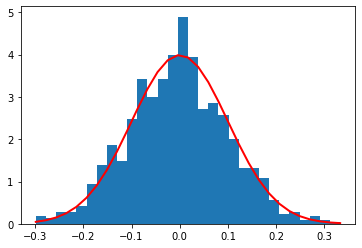

In [24]:
import matplotlib.pyplot as plt

mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

mean = (1, 2)
cov = [[100, 0], [0, 1]]
x = np.random.multivariate_normal(mean, cov, (3, 3))

In [25]:
# cam_i_in_robot = np.eye(3)
# cam_i_in_robot[:,0] = np.array([0,1,0])
# cam_i_in_robot[:,1] = np.array([0,0,-1])
# cam_i_in_robot[:,2] = np.array([1,0,0])

# print(cam_i_in_robot)